In [1]:
# PS6 - CE264
# GSI: Mustapha Harb, Mengqiao Yu, Andrew Campbell

# importing the requried libraries
from collections import OrderedDict    # For recording the model specification 

import pandas as pd                    # For file input/output
import numpy as np                     # For vectorized math operations

import pylogit as pl                   # For MNL model estimation and
                                       # conversion from wide to long format
    
%matplotlib inline

# reading the data file 
data_wide  = pd.read_csv("data01.csv",sep=",")

# Problem 1: MNL Evaluation

## Build the MNL specifications to predict mode choice 

In [2]:
# converting the data from wide to long format

# Create the list of individual specific variables
ind_variables = data_wide.columns.tolist()[:2] + ["weights"]

# Specify the variables that vary across individuals and some or all alternatives
# The keys are the column names that will be used in the long format dataframe.
# The values are dictionaries whose key-value pairs are the alternative id and
# the column name of the corresponding column that encodes that variable for
# the given alternative. Examples below.
alt_varying_variables = {u'travel_time': dict([(1, 'tt_da'),
                                               (2, 'tt_sr'),
                                               (3, 'tt_walk'),
                                               (4, 'tt_bike'),
                                               (5, 'tt_wt'),
                                               (6, 'tt_dt')]),
                          u'distance_car': dict([(1, 'dist_car'),
                                                (2, 'dist_car')]),
                          u'travel_cost': dict([(1, 'cost_da'),
                                                (2, 'cost_sr'),
                                                (5, 'cost_wt'),
                                                (6, 'cost_dt')]),
                          u'access_time': dict([(5, 'accTime_wt'),
                                                (6, 'accTime_dt')]),
                          u'egress_time': dict([(5, 'egrTime_wt'),
                                                (6, 'egrTime_dt')]),
                          u'initial_wait': dict([(5, 'iWait_wt'),
                                                 (6, 'iWait_dt')]),
                          u'transfer_wait': dict([(5, 'xWait_wt'),
                                                  (6, 'xWait_dt')]),
                          u'access_distance_dt': dict([(6, "accDist_dt")])}

# Specify the availability variables
# Note that the keys of the dictionary are the alternative id's.
# The values are the columns denoting the availability for the
# given mode in the dataset.


availability_variables = {1: 'avail_da',
                          2: 'avail_sr', 
                          3: 'avail_walk',
                          4: 'avail_bike',
                          5: 'avail_wt',
                          6: 'avail_dt'}

##########
# Determine the columns for: alternative ids, the observation ids and the choice
##########
# The 'custom_alt_id' is the name of a column to be created in the long-format data
# It will identify the alternative associated with each row.
custom_alt_id = "mode_id"

# Create a custom id column that ignores the fact that this is a 
# panel/repeated-observations dataset. Note the +1 ensures the id's start at one.
obs_id_column = "obsID"

# Create a variable recording the choice column
choice_column = "choice"

In [3]:
# Perform the conversion to long-format
data_long = pl.convert_wide_to_long(data_wide, 
                                           ind_variables, 
                                           alt_varying_variables, 
                                           availability_variables, 
                                           obs_id_column, 
                                           choice_column,
                                           new_alt_id_name=custom_alt_id)

In [4]:
##########
# Create scaled variables so the estimated coefficients are of similar magnitudes
##########
# Scale the travel time column by 60 to convert raw units (minutes) to hours
data_long["travel_time_hrs"] = data_long["travel_time"] / 60.0

# Scale the access by 60 to convert raw units (minutes) to hours
data_long["access_time_hrs"] = data_long["access_time"] / 60.0

# for drive to transit let us combine travel time and access time
data_long["travel_time_access_time_hrs"] = data_long["travel_time_hrs"] + data_long["access_time_hrs"]

#Scale the egress time by 60
data_long["egress_time_hrs"] = data_long["egress_time"] / 60.0

# combining access and egress time which we want to use for the walk to transit alternative
data_long["acess_egress_hrs"] = data_long["access_time_hrs"] + data_long["egress_time_hrs"]

# scaling the initial wait by 60
data_long["initial_wait_hrs"] = data_long["initial_wait"] / 60.0

# scaling the transfer wait by 60
data_long["transfer_wait_hrs"]  = data_long["transfer_wait"] / 60.0

# combining transfer wait and initial wait to be used for walk to transit and bike to transit
data_long["initial_transfer_wait_hrs"] = data_long["initial_wait_hrs"] + data_long["transfer_wait_hrs"]


# creating non-linear transformations for the cost variable
cutOff1 = 2
cutOff2 = 7


data_long["cost_cat_one"] = (data_long["travel_cost"] <= cutOff1)*data_long["travel_cost"] + (data_long["travel_cost"] > cutOff1)*cutOff1

data_long["cost_cat_two"] = (data_long["travel_cost"] > cutOff1)*(data_long["travel_cost"] <= cutOff2)*(data_long["travel_cost"] - cutOff1) + (data_long["travel_cost"] > cutOff2)* (cutOff2 - cutOff1)

data_long["cost_cat_three"] = (data_long["travel_cost"] > cutOff2)*(data_long["travel_cost"] - cutOff2)



# specifying the utility equations

# NOTE: - Specification and variable names must be ordered dictionaries.
#       - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         of integers or or lists of lists of integers. Within a list, 
#         or within the inner-most list, the integers should be the 
#         alternative ID's of the alternative whose utility specification 
#         the explanatory variable is entering. Lists of lists denote 
#         alternatives that will share a common coefficient for the variable
#         in question.

basic_specification = OrderedDict()
basic_names = OrderedDict()


basic_specification["intercept"] = [ 2, 3, 4, 5, 6]
basic_names["intercept"] = ['ASC SR',
                            'ASC Walk', 'ASC Bike', 'ASC WT', 'ASC DT']

basic_specification["travel_time_hrs"] = [[1, 2, 5], 4, 3]
basic_names["travel_time_hrs"] = ['In-Vehicle Travel Time, units:hrs (DA, SR, WT)',
                                  'Bike Time, units:hrs (Bike)',
                                  'Walk Time, units:hrs (Walk)']

basic_specification["travel_time_access_time_hrs"] = [6]
basic_names["travel_time_access_time_hrs"] = ["In-Vehicle Travel Time, units:hrs, (DT)"]

basic_specification["acess_egress_hrs"] = [5]
basic_names["acess_egress_hrs"] = ["Walk Time, units:hrs, (WT)"]

basic_specification["egress_time_hrs"] = [6]
basic_names["egress_time_hrs"] = ["Walk Time, units:hrs, (DT)"]

basic_specification["initial_transfer_wait_hrs"] = [[5, 6]]
basic_names["initial_transfer_wait_hrs"] = ["Waiting Time, units:hrs, (WT and DT)"]


basic_specification["cost_cat_one"] = [[1, 2, 5,6]]
basic_names["cost_cat_one"] = ['Cost: Under $2']

basic_specification["cost_cat_two"] = [[1, 2, 5,6]]
basic_names["cost_cat_two"] = ['Cost: (2 - 7)$']

basic_specification["cost_cat_three"] = [[1, 2, 5,6]]
basic_names["cost_cat_three"] = ['Cost: Above $7']



C:\Users\lisiq\Anaconda2\lib\site-packages\pandas\core\computation\expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


## 1.a - Split into training and test data

In [5]:
### taking a sample of 10,000 observation from the BATS 2000 dataset 
# and split it into train and test sets
train_size = 8000
total_size = 10000

# Suffle the data before sampling
np.random.seed(1138)  
shuffled = np.random.choice(data_long.obsID.unique()[0:total_size], total_size, replace=False)
train_ids = shuffled[0:train_size]
test_ids = shuffled[train_size:]

new_data_train = data_long.loc[data_long[obs_id_column].isin(train_ids)].copy()
new_data_test = data_long.loc[data_long[obs_id_column].isin(test_ids)].copy()

In [6]:
print train_ids.size
print test_ids.size

8000
2000


### Estimate model and inspect results

In [7]:
# Estimate the multinomial logit model (MNL)
data_mnl = pl.create_choice_model(data=new_data_train,
                                  alt_id_col=custom_alt_id,
                                  obs_id_col=obs_id_column,
                                  choice_col=choice_column,
                                  specification=basic_specification,
                                  model_type="MNL",
                                  names=basic_names)

# Specify the initial values and method for the optimization.
data_mnl.fit_mle(np.zeros(15))

Log-likelihood at zero: -10,256.1117
Initial Log-likelihood: -10,256.1117


C:\Users\lisiq\Anaconda2\lib\site-packages\scipy\optimize\_minimize.py:385: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.38 seconds.
Final log-likelihood: -6,425.5538


In [8]:
# Look at the estimation results
data_mnl.get_statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                8,000
Model:             Multinomial Logit Model   Df Residuals:                    7,985
Method:                                MLE   Df Model:                           15
Date:                     Tue, 24 Apr 2018   Pseudo R-squ.:                   0.373
Time:                             17:00:49   Pseudo R-bar-squ.:               0.372
AIC:                            12,881.108   Log-Likelihood:             -6,425.554
BIC:                            12,985.915   LL-Null:                   -10,256.112
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
ASC SR                                            -2.1269      0.055    -38.520      0.000      -2.235      -2.019
ASC Walk                                          -2.0496      0.203    -10.105      0.000      -2.447      -1.652
ASC Bike                                          -2.8861      0.194    -14.913      0.000      -3.265      -2.507
ASC WT                                             1.4843      0.176      8.415      0.000       1.139       1.830
ASC DT                                            -0.7238      0.206     -3.505      0.000      -1.129      -0.319
In-Vehicle Travel Time, units:hrs (DA, SR, WT)    -1.9197      0.106    -18.086      0.000      -2.128      -1.712
Bike Time, units:hrs (Bike)                       -6.2048      0.440    -14.095      0.000      -7.068      -5.342
Walk Time, units:hrs (Walk)                       -1.4945      0.142    -10.528      0.000      -1.773      -1.216
In-Vehicle Travel Time, units:hrs, (DT)           -1.2401      0.136     -9.136      0.000      -1.506      -0.974
Walk Time, units:hrs, (WT)                        -2.9691      0.258    -11.500      0.000      -3.475      -2.463
Walk Time, units:hrs, (DT)                        -5.5941      0.442    -12.664      0.000      -6.460      -4.728
Waiting Time, units:hrs, (WT and DT)              -2.8204      0.257    -10.994      0.000      -3.323      -2.318
Cost: Under $2                                    -1.3609      0.072    -18.843      0.000      -1.502      -1.219
Cost: (2 - 7)$                                    -0.3295      0.021    -15.635      0.000      -0.371      -0.288
Cost: Above $7                                    -0.0850      0.011     -7.709      0.000      -0.107      -0.063
==================================================================================================================
"""

## 1.b - MNL Prediction

#### Use the model estimated on the *training data* to predict the probability of each mode for the *test data* 

In [9]:
prediction_array_test = data_mnl.predict(new_data_test)

In [10]:
#add the predicted probabilities to the test dataset
new_data_test['predict'] = prediction_array_test

### Calculate the accuracy of our MNL model for the *test data*

In [11]:
idx_test = new_data_test.groupby(u'obsID').apply(lambda x: np.argmax(x.predict))  # indices of predicted choices in the long data
predicted_actual_test = new_data_test.loc[idx_test, :]['choice']  # actual outcomes for the predicted choices                                                                                                              # [0 = pred wrong, 1 = pred right]
accuracy_test = np.true_divide(np.sum(predicted_actual_test), predicted_actual_test.size)
print accuracy_test

0.696


<font color=red> 
### The accuracy of the MNL model is 0.696

## Evaluate the model across a range of training sizes

### Training and test accuracy

Make a plot comparing training and test accuracy for differenet training sample size. Keep the total_size fixed at 10,000, but range across the train_size. Make sure you clude some small training sample sizes. I recommend using some different intervals like: [100, 200, 500, 1000, 2000, 3000, ... 9000]

Use the above code as template. We recommend using a for loop to iterate through all the train_size values instead of doing it manually.

### Helpful functions

The following two functions should simplify things for your for loops.

In [12]:
# Function to return shuffled training and data sets
def split_data(data, train_size, test_size, seed=1138):
    """
    Takes a long-form DataFrame and returns mutually exclusive training and test samples of specificed lengths. Input
    data observation ids are shuffled to ensure random draws for samples.
    
    Keyword arguments:
    data -- long format DataFrame
    train_size -- integer size of training sample
    test_size -- integer size of test sample
    seed -- integer to set random seed for Numpy
    """
    # Suffle the data before sampling
    np.random.seed(seed)  
    shuffled = np.random.choice(data.obsID.unique()[0:train_size+test_size], train_size+test_size, replace=False)
    train_ids = shuffled[0:train_size]
    test_ids = shuffled[train_size:]

    train = data.loc[data[obs_id_column].isin(train_ids)].copy()
    test = data.loc[data[obs_id_column].isin(test_ids)].copy()
    return (train, test)

In [13]:
# Function to calculate the accuracy and log-likelihood using a trained MNL and data
def eval_prediction(model, data):
    """
    Function to calculate to evaluate model estimates. It returns a tuple of 1) accuracy, 2) log-likelihood
    3) null log-likelihood  4) likelihood ratio index and 5) adjusted likelihood ratio index
    
    Keyword arguments:
    model -- a trained PyLogit model
    data -- (N x K) Pandas DataFrame long format. Same attributes as that used to train the model
    
    returns -- Tuple: (accuracy, log-likelihood, null log-likelihood, likelihood ratio index,
    adjusted likelihood ratio index)
    """
    ##
    # Calculate the accuracy
    ##
    
    # Predicted choice probabilities 
    prediction_array = model.predict(data)
    data['predict'] = prediction_array
    idx = data.groupby(u'obsID').apply(lambda x: np.argmax(x.predict))  # indices of predicted choices in the long data
    predicted_actual = data.loc[idx, :]['choice']  # actual outcomes for the predicted choices
    accuracy = np.true_divide(np.sum(predicted_actual), predicted_actual.size)
    
    ##
    # Calculate the log-likelihood
    ##
    ll = np.dot(data.choice, np.log(prediction_array))
    
    ##
    # Calculate the likelihood ratio index
    ##

    # calc the null predictions
    null_prediction_array = data.groupby(u'obsID')[u'obsID'].transform(lambda x: np.true_divide(1, x.shape[0]))
    ll_0 = np.dot(data.choice, np.log(null_prediction_array))
    rho_2 = 1 - np.abs(np.true_divide(ll,ll_0))
    
    ##
    # Calc adjusted likelihood ratio index
    ##
    rho_bar_2 = 1 - np.abs(np.true_divide(ll - model.params.shape[0], ll_0))
    
    return (accuracy, ll, ll_0, rho_2, rho_bar_2)

### Log-likelihood

Plot the training and test log-likelihoods of the model for the same training sizes used above. Either add a second y-axis to the accuracy plot, or make a new plot.

In [ ]:
eval_prediction(data_mnl, train)
fig = figure()
ax = fig.add_subplot(111)
line = ax.plot(eval_prediction.accuracy,eval_prediction.ll,'-b',label='Accuracy of train data')
plt.ylabel=("Accuracy of train data")
plt.xlabel=("ll of train data")
plt.legend()

In [36]:
eval_prediction(data_mnl, test)
fig = figure()
ax = fig.add_subplot(111)
line = ax.plot(eval_prediction.accuracy,eval_prediction.ll,'-g',label='Accuracy of test data')
plt.ylabel=("Accuracy of test data")
plt.xlabel=("ll of test data")
plt.legend()

NameError: name 'test' is not defined

=======================================================================================================================

# Problem 2: Use ML algorithms we learned in class to predict mode choice

<font color=blue>
### The next 3 cells are just to fix the data to match the dataset used to train the MNL model

In [14]:
df = data_wide
df = df[:9999]
np.random.seed(100)

In [15]:
mins_to_hours_cols = ['tt_da', 'tt_sr', 'tt_walk', 'tt_bike', 
                     'tt_wt', 'accTime_wt', 'egrTime_wt',
                     'iWait_wt', 'xWait_wt', 'tt_dt', 
                     'accTime_dt','egrTime_dt', 'iWait_dt', 
                     'xWait_dt']

for col in mins_to_hours_cols:
    df[col+"_hrs"] = df[col]/60

df["travel_time_access_time_hrs_dt"] = df["tt_dt_hrs"] + df["accTime_dt_hrs"]
df["travel_time_access_time_hrs_wt"] = df["tt_wt_hrs"] + df["accTime_wt_hrs"]

df["access_egress_hrs_dt"] = df["accTime_dt_hrs"] + df["egrTime_dt_hrs"]
df["access_egress_hrs_wt"] = df["accTime_wt_hrs"] + df["egrTime_wt_hrs"]

df["initial_transfer_wait_hrs_dt"] = df["iWait_dt_hrs"] + df["xWait_dt_hrs"]
df["initial_transfer_wait_hrs_wt"] = df["iWait_wt_hrs"] + df["xWait_wt_hrs"]

# creating non-linear transformations for the cost variable
cutOff1 = 2
cutOff2 = 7

df["cost_cat_one_da"] = (df['cost_da']<=cutOff1)*df['cost_da'] + (df['cost_da'] > cutOff1)*cutOff1
df["cost_cat_two_da"] = (df['cost_da'] > cutOff1)*(df['cost_da'] <= cutOff2)*(df['cost_da'] - cutOff1) + (df['cost_da'] > cutOff2)* (cutOff2 - cutOff1)
df["cost_cat_three_da"] = (df['cost_da'] > cutOff2)*(df['cost_da'] - cutOff2)

df["cost_cat_one_sr"] = (df['cost_sr']<=cutOff1)*df['cost_sr'] + (df['cost_sr'] > cutOff1)*cutOff1
df["cost_cat_two_sr"] = (df['cost_sr'] > cutOff1)*(df['cost_sr'] <= cutOff2)*(df['cost_sr'] - cutOff1) + (df['cost_sr'] > cutOff2)* (cutOff2 - cutOff1)
df["cost_cat_three_sr"] = (df['cost_sr'] > cutOff2)*(df['cost_sr'] - cutOff2)

df["cost_cat_one_dt"] = (df['cost_dt']<=cutOff1)*df['cost_dt'] + (df['cost_dt'] > cutOff1)*cutOff1
df["cost_cat_two_dt"] = (df['cost_dt'] > cutOff1)*(df['cost_dt'] <= cutOff2)*(df['cost_dt'] - cutOff1) + (df['cost_dt'] > cutOff2)* (cutOff2 - cutOff1)
df["cost_cat_three_dt"] = (df['cost_dt'] > cutOff2)*(df['cost_dt'] - cutOff2)

df["cost_cat_one_wt"] = (df['cost_wt']<=cutOff1)*df['cost_wt'] + (df['cost_wt'] > cutOff1)*cutOff1
df["cost_cat_two_wt"] = (df['cost_wt'] > cutOff1)*(df['cost_wt'] <= cutOff2)*(df['cost_wt'] - cutOff1) + (df['cost_wt'] > cutOff2)* (cutOff2 - cutOff1)
df["cost_cat_three_wt"] = (df['cost_wt'] > cutOff2)*(df['cost_wt'] - cutOff2)


C:\Users\lisiq\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\lisiq\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lisiq\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://p

In [16]:
all_cols = pd.DataFrame(df.columns,columns=["col_name"])

In [17]:
cols = list(df.columns.values)
cols_to_include = (cols[45:] + ["egrTime_wt_hrs","egrTime_dt_hrs"]+
                   cols[23:29] + cols[31:36] + ["tt_dt_hrs"] + ["choice"])

new_df = df[cols_to_include]

### use sklearn to split the data into a training and testing sets

In [18]:
from sklearn import model_selection

X = new_df.drop(["choice"],axis=1)
y = new_df["choice"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                    test_size=0.2, 
                                                                    shuffle = False)

## Training and testing a KNN algorithm

In [ ]:
from sklearn import neighbors

### plot graph of accuracy vs. number of neighors for train dataset

0.767845980748
0.741842730341
0.740092511564
0.72259032379
0.722965370671
0.710088761095
0.708713589199
0.701462682835
0.700087510939
0.695086885861
0.694086760845
0.688836104513
0.688461057632
0.685335666958
0.681335166896
0.680710088761
0.680460057507
0.679209901238
0.679584948119
0.677334666833
0.677959744968
0.675334416802
0.672709088636
0.672334041755
0.672084010501
0.669208651081


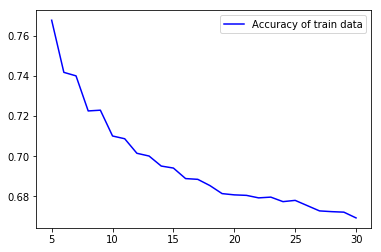

In [44]:
acc_train=[]
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
max=[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
for i in max:
    KNN_classifier = neighbors.KNeighborsClassifier(n_neighbors=i)
    KNN_classifier.fit(X=X_train,y=y_train)
    KNN_predictions= KNN_classifier.predict(X_train)
    accscore_train=sum(KNN_predictions == y_train)/float(len(KNN_predictions))
    acc_train.append(accscore_train)
    print(accscore_train)
fig = figure()
ax1 = fig.add_subplot(111)
line1 = ax1.plot(max,acc_train,'-b',label='Accuracy of train data')
plt.ylabel=("Accuracy of train data")
plt.xlabel=("Number of neighbors")
plt.legend()

### plot graph of accuracy vs. number of neighors for test dataset

0.6415
0.6475
0.647
0.657
0.6575
0.66
0.656
0.664
0.661
0.6645
0.6635
0.666
0.663
0.6695
0.6695
0.6715
0.673
0.673
0.672
0.6725
0.6765
0.672
0.6755
0.673
0.6765
0.679


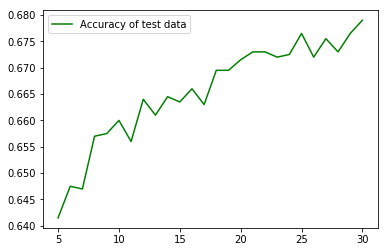

In [48]:
acc_test=[]
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
for i in max:
    KNN_classifier = neighbors.KNeighborsClassifier(n_neighbors=i)
    KNN_classifier.fit(X=X_train,y=y_train)
    KNN_predictions= KNN_classifier.predict(X_test)
    accscore_test=sum(KNN_predictions == y_test)/float(len(KNN_predictions))
    acc_test.append(accscore_test)
    print(accscore_test)
fig = figure()
ax2 = fig.add_subplot(111)
line1 = ax2.plot(max,acc_test,'-g',label='Accuracy of test data')
plt.ylabel=("Accuracy of test data")
plt.xlabel=("Number of neighbors")
plt.legend()

# Train and test a decision tree classifier

In [50]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

### plot graph of accuracy vs. max_depth for train dataset

0.650956369546
0.651956494562
0.653456682085
0.668083510439
0.674834354294
0.683710463808
0.693586698337
0.712839104888
0.735966995874
0.758219777472
0.780722590324
0.801600200025
0.826478309789
0.845230653832
0.859107388424


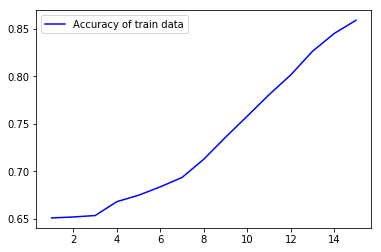

In [59]:
acc_train1=[]
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
max1=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
for i in max1:
    Decision_Tree_Clasifier=tree.DecisionTreeClassifier(max_depth=i)
    Decision_Tree_Clasifier.fit(X=X_train,y=y_train)
    Decision_Tree_predictions = Decision_Tree_Clasifier.predict(X_train)
    accscore_train=sum(Decision_Tree_predictions == y_train)/float(len(Decision_Tree_predictions))
    acc_train1.append(accscore_train)
    print(accscore_train)
fig = figure()
ax3 = fig.add_subplot(111)
line3 = ax3.plot(max1,acc_train1,'-b',label='Accuracy of train data')
plt.ylabel=("Accuracy of train data")
plt.xlabel=("Max Depth")
plt.legend()

### plot graph of accuracy vs. Max depth for test dataset

In [66]:
acc_test1=[]
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
max1=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
for i in max1:
    Decision_Tree_Clasifier=tree.DecisionTreeClassifier(max_depth=i)
    Decision_Tree_Clasifier.fit(X=X_train,y=y_train)
    Decision_Tree_predictions = Decision_Tree_Clasifier.predict(X_test)
    accscore_test=sum(Decision_Tree_predictions == y_test)/float(len(Decision_Tree_predictions))
    acc_test1.append(accscore_test)
    print(accscore_test)


0.662
0.6635
0.664
0.6795
0.6855
0.6845
0.6855
0.6795
0.6825
0.6735
0.673
0.6725
0.664
0.663
0.6575


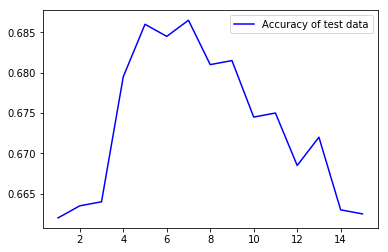

In [65]:
fig = figure()
ax4 = fig.add_subplot(111)
line4 = ax4.plot(max1,acc_test1,'-b',label='Accuracy of test data')
plt.ylabel=("Accuracy of test data")
plt.xlabel=("Max Depth")
plt.legend()
plt.show()

# Train and test a Random forest classifier

In [68]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier

### plot graph of accuracy vs. number of trees for train dataset

In [79]:
acc_train2=[]
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
max2=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
for i in max2:
    Random_Forest_Clasifier=ensemble.RandomForestClassifier(max_depth=5, n_estimators=i, max_features=1)
    Random_Forest_Clasifier.fit(X=X_train,y=y_train)
    Random_Forest_predictions = Random_Forest_Clasifier.predict(X_train)
    accscore_train=sum(Random_Forest_predictions == y_train)/float(len(Random_Forest_predictions))
    acc_train2.append(accscore_train)
    print(accscore_train)



0.63970496312
0.664708088511
0.647205900738
0.647955994499
0.641455181898
0.647205900738
0.648206025753
0.644080510064
0.642455306913
0.643330416302
0.649831228904
0.640455056882
0.644455556945
0.642455306913
0.642330291286


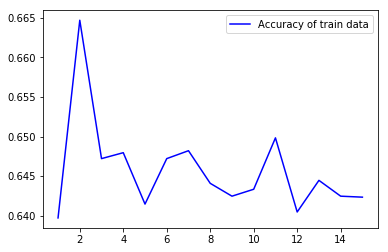

In [80]:
fig = figure()
ax5 = fig.add_subplot(111)
line5 = ax5.plot(max2,acc_train2,'-b',label='Accuracy of train data')
plt.ylabel=("Accuracy of train data")
plt.xlabel=("Number of Trees")
plt.legend()

### plot graph of accuracy vs. Number of trees for test dataset

In [81]:
acc_test2=[]
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
for i in max2:
    Random_Forest_Clasifier=ensemble.RandomForestClassifier(max_depth=5, n_estimators=i, max_features=1)
    Random_Forest_Clasifier.fit(X=X_train,y=y_train)
    Random_Forest_predictions = Random_Forest_Clasifier.predict(X_test)
    accscore_test=sum(Random_Forest_predictions == y_test)/float(len(Random_Forest_predictions))
    acc_test2.append(accscore_test)
    print(accscore_test)



0.6515
0.6665
0.657
0.659
0.6665
0.6535
0.655
0.66
0.658
0.6535
0.6535
0.653
0.655
0.6525
0.6545


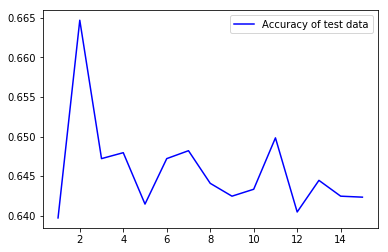

In [83]:
fig = figure()
ax5 = fig.add_subplot(111)
line5 = ax5.plot(max2,acc_train2,'-b',label='Accuracy of test data')
plt.ylabel=("Accuracy of test data")
plt.xlabel=("Nmuber of Trees")
plt.legend()

# Train and test a SVM classifier

In [19]:
from sklearn import svm
from sklearn.svm import SVC

### plot graph of accuracy vs. Cost Penalty for train dataset

In [35]:
acc_train3=[]
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
max3=[0.1,0.5,0.7,1,10,50]
for i in max3:
    SVM_Clasifier=svm.SVC(kernel="linear", C=i)
    SVM_Clasifier.fit(X=X_train,y=y_train)
    SVM_predictions = SVM_Clasifier.predict(X_train)
    accscore_train=sum(SVM_predictions == y_train)/float(len(SVM_predictions))
    acc_train3.append(accscore_train)
    print(accscore_train)


0.707463432929
0.728091011376
0.7295911989
0.732591573947
0.737217152144
0.737342167771


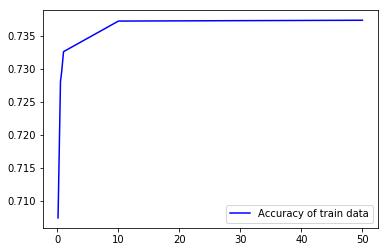

In [37]:
fig = figure()
ax6 = fig.add_subplot(111)
line6 = ax6.plot(max3,acc_train3,'-b',label='Accuracy of train data')
plt.ylabel=("Accuracy of train data")
plt.xlabel=("Cost Penalty")
plt.legend()

### plot graph of accuracy vs. cost penalty for test dataset

In [38]:
acc_test3=[]
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
for i in max3:
    SVM_Clasifier=svm.SVC(kernel="linear", C=i)
    SVM_Clasifier.fit(X=X_train,y=y_train)
    SVM_predictions = SVM_Clasifier.predict(X_test)
    accscore_test=sum(SVM_predictions == y_test)/float(len(SVM_predictions))
    acc_test3.append(accscore_test)
    print(accscore_test)

0.713
0.743
0.7465
0.7485
0.7515
0.749


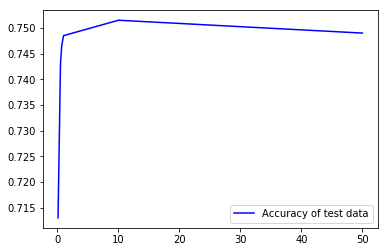

In [39]:
fig = figure()
ax7 = fig.add_subplot(111)
line7 = ax7.plot(max3,acc_test3,'-b',label='Accuracy of test data')
plt.ylabel=("Accuracy of test data")
plt.xlabel=("Cost Penalty")
plt.legend()

# Create table for all the algorithms you used and their highest accuracy (including your MNL model)

In [12]:
summary=[["MNL",0.696],["KNN",0.679],["Decision Tree",0.6855],["Random Forest",0.6665],["SVM",0.7515]]
print ("Algorithm:%-15s Highest Accuracy:%-8.2f"%(summary[0][0],summary[0][1]))
print ("Algorithm:%-15s Highest Accuracy:%-8.2f"%(summary[1][0],summary[1][1]))
print ("Algorithm:%-15s Highest Accuracy:%-8.2f"%(summary[2][0],summary[2][1]))
print ("Algorithm:%-15s Highest Accuracy:%-8.2f"%(summary[3][0],summary[3][1]))

Algorithm:MNL             Highest Accuracy:0.70    
Algorithm:KNN             Highest Accuracy:0.68    
Algorithm:Decision Tree   Highest Accuracy:0.69    
Algorithm:Random Forest   Highest Accuracy:0.67    
